# Wireless Repeater Detection Simulation

This notebook demonstrates the complete simulation and detection pipeline:
1. Generate BTS and unauthorized repeaters
2. Simulate drive test measurements with Friis equation
3. Detect repeaters using statistical anomaly detection
4. Visualize results on interactive maps

## Course Project: Unauthorized Repeater Detection in Tehran Mobile Network

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Import project modules
from pkg.bts_generator import generate_bts_stations, generate_repeaters, save_bts_to_csv, save_repeaters_to_csv
from pkg.drive_test_simulator import simulate_drive_test
from pkg.detection import detect_repeaters, validate_detection, build_expected_coverage_map, calculate_residuals
from pkg.visualization import create_main_detection_map, create_comparison_maps, plot_residual_histogram, plot_detection_metrics

print("All modules loaded successfully!")

All modules loaded successfully!


## Step 1: Generate BTS Network and Unauthorized Repeaters

In [2]:
# Generate BTS stations
print("Generating BTS stations...")
bts_stations = generate_bts_stations()

# Save to CSV
save_bts_to_csv(bts_stations)

# Display BTS info
bts_df = pd.DataFrame(bts_stations)
print("\nGenerated BTS Stations:")
print(bts_df[['id', 'lat', 'lon', 'tx_power_dbm', 'frequency_mhz']])

Generating BTS stations...
Generated 23 BTS stations
Saved 23 BTS to ./data/bts_stations.csv

Generated BTS Stations:
         id        lat        lon  tx_power_dbm  frequency_mhz
0   BTS_001  35.720266  51.500422     44.550530           1800
1   BTS_002  35.729275  51.500422     45.125817           1800
2   BTS_003  35.738284  51.500422     44.598623           1800
3   BTS_004  35.747293  51.500422     43.321280           1800
4   BTS_005  35.756302  51.500422     43.402614           1800
5   BTS_006  35.724771  51.509835     44.044777           1800
6   BTS_007  35.733780  51.509835     46.085119           1800
7   BTS_008  35.742789  51.509835     43.531209           1800
8   BTS_009  35.751798  51.509835     46.864230           1800
9   BTS_010  35.720266  51.519249     44.298199           1800
10  BTS_011  35.729275  51.519249     44.232760           1800
11  BTS_012  35.738284  51.519249     43.009763           1800
12  BTS_013  35.747293  51.519249     45.565983           1800


In [3]:
# Generate unauthorized repeaters
print("Generating unauthorized repeaters...")
repeaters = generate_repeaters(
    bts_list=bts_stations,
    random_seed=43
)

# Save to CSV
save_repeaters_to_csv(repeaters)

# Display repeater info
repeater_df = pd.DataFrame(repeaters)
print("\nGenerated Unauthorized Repeaters:")
print(repeater_df[['id', 'lat', 'lon', 'gain_db', 'serving_bts_id']])

Generating unauthorized repeaters...
Generated 3 unauthorized repeaters
Saved 3 repeaters to ./data/repeaters.csv

Generated Unauthorized Repeaters:
        id        lat        lon  gain_db serving_bts_id
0  REP_001  35.755375  51.500444       30        BTS_005
1  REP_002  35.746222  51.536443       30        BTS_017
2  REP_003  35.744785  51.501868       30        BTS_003


## Step 2: Simulate Drive Test Measurements

Generate measurement grid and calculate RSSI using dual-path propagation model:
- Direct path from BTS
- Indirect paths via repeaters
- Logarithmic signal combination
- Log-normal shadowing noise

In [4]:
# Run drive test simulation
print("Running drive test simulation...")
measurements = simulate_drive_test(
    bts_list=bts_stations,
    repeater_list=repeaters,
    add_noise=True,
    save_to_csv=True
)

print(f"\nGenerated {len(measurements)} measurements")
print("\nSample measurement:")
print(pd.DataFrame([measurements[0]]))

Running drive test simulation...
Generated 1849 measurement points (grid spacing: 100m)
Simulating drive test with 1849 measurement points...
BTS: 23, Repeaters: 3
Noise: enabled (sigma=4 dB)
Processed 1000/1849 points...
Drive test simulation complete! Total measurements: 1849
Saved 1849 measurements to ./data/drive_test_measurements.csv

Generated 1849 measurements

Sample measurement:
   measurement_id                  timestamp        lat        lon  \
0               1 2026-01-03 01:00:14.296634  35.720266  51.500422   

  serving_cell_id  serving_rssi  rssi_BTS_001  rssi_BTS_002  rssi_BTS_003  \
0         BTS_001           -50           -50    -81.288891     -92.11935   

   rssi_BTS_004  ...  rssi_BTS_014  rssi_BTS_015  rssi_BTS_016  rssi_BTS_017  \
0    -95.384638  ...   -102.978009    -84.009928    -98.835409     -96.52887   

   rssi_BTS_018  rssi_BTS_019  rssi_BTS_020  rssi_BTS_021  rssi_BTS_022  \
0    -97.118908    -98.566806    -97.512644    -97.860739    -98.514941   

 

## Step 3: Detect Unauthorized Repeaters

Detection pipeline:
1. Build expected coverage map (without repeaters)
2. Calculate residuals (actual - predicted)
3. Statistical anomaly detection (z-score)
4. Spatial clustering (DBSCAN)
5. Repeater localization (weighted centroid)

In [5]:
# Run detection algorithm
detected_repeaters = detect_repeaters(
    measurements=measurements,
    bts_list=bts_stations
)

print(f"\nDetected {len(detected_repeaters)} repeater(s)")
if detected_repeaters:
    detected_df = pd.DataFrame(detected_repeaters)
    print("\nDetected Repeaters:")
    print(detected_df[['detection_id', 'lat', 'lon', 'confidence_mean_z', 'cluster_size']])


REPEATER DETECTION PIPELINE
Building expected coverage map (without repeaters)...
Generated predictions for 1849 points
Calculating residuals (actual - predicted)...
One-sided z-score detection (threshold: 2.5, min residual: 12.0 dB)
Baseline: median=0.01 dB, noise_std=3.98 dB
Detected 51 anomalous points
Clustering anomalies with DBSCAN (eps=400m, min_samples=3)...
Found 5 anomaly clusters

Localizing repeaters for 5 clusters...

Detected Repeater #0:
  Location: (35.723939, 51.529781)
  Confidence (mean z-score): 3.30
  Cluster size: 3 points

Detected Repeater #1:
  Location: (35.725372, 51.544251)
  Confidence (mean z-score): 3.12
  Cluster size: 3 points

Detected Repeater #2:
  Location: (35.731267, 51.506943)
  Confidence (mean z-score): 3.17
  Cluster size: 7 points

Detected Repeater #3:
  Location: (35.730128, 51.531559)
  Confidence (mean z-score): 3.46
  Cluster size: 5 points

Detected Repeater #4:
  Location: (35.754282, 51.535781)
  Confidence (mean z-score): 3.45
  Clu

## Step 4: Validate Detection Results


DETECTION VALIDATION

Detected Repeater: DETECTED_0
  Detected at: (35.723939, 51.529781)
  Actual at:   (35.746222, 51.536443)
  Error: 2544.9 meters
  Confidence: 3.30

Detected Repeater: DETECTED_1
  Detected at: (35.725372, 51.544251)
  Actual at:   (35.746222, 51.536443)
  Error: 2418.9 meters
  Confidence: 3.12

Detected Repeater: DETECTED_2
  Detected at: (35.731267, 51.506943)
  Actual at:   (35.744785, 51.501868)
  Error: 1568.5 meters
  Confidence: 3.17

Detected Repeater: DETECTED_3
  Detected at: (35.730128, 51.531559)
  Actual at:   (35.746222, 51.536443)
  Error: 1839.6 meters
  Confidence: 3.46

Detected Repeater: DETECTED_4
  Detected at: (35.754282, 51.535781)
  Actual at:   (35.746222, 51.536443)
  Error: 896.2 meters
  Confidence: 3.45

Detection Rate: 166.7% (5/3)
Mean Error: 1853.6 meters
Median Error: 1839.6 meters



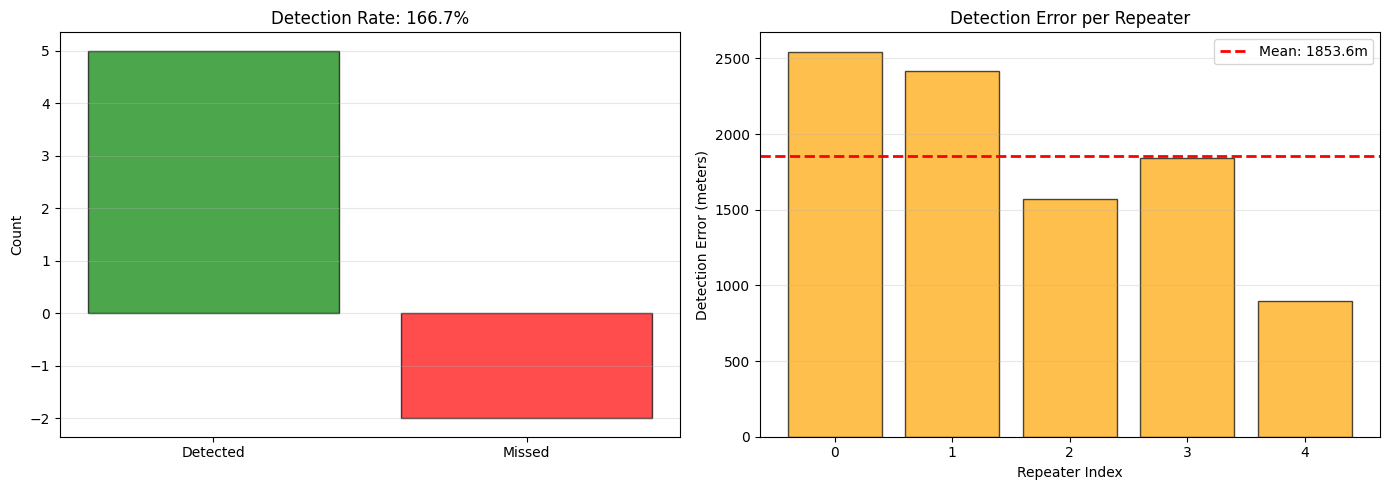

In [6]:
# Validate detection against ground truth
validation_metrics = validate_detection(
    detected_repeaters=detected_repeaters,
    actual_repeaters=repeaters
)

# Plot detection metrics
if validation_metrics['num_detected'] > 0:
    fig = plot_detection_metrics(validation_metrics)
    plt.show()

## Step 5: Visualize Results

### 5.1 Main Detection Map

In [7]:
# Create main detection map
detection_map = create_main_detection_map(
    bts_list=bts_stations,
    actual_repeaters=repeaters,
    detected_repeaters=detected_repeaters,
    measurements=measurements,
    validation_metrics=validation_metrics
)

# Display map in notebook
detection_map

Creating main detection map...


### 5.2 Coverage Comparison Maps

In [8]:
# Build expected coverage for comparison
predictions = build_expected_coverage_map(
    bts_list=bts_stations,
    measurement_points=measurements,
    add_noise=False
)

# Create side-by-side comparison
create_comparison_maps(
    bts_list=bts_stations,
    measurements=measurements,
    predictions=predictions
)

print("Side-by-side comparison maps created!")

Building expected coverage map (without repeaters)...
Generated predictions for 1849 points
Creating comparison maps...


Side-by-side comparison maps created!


### 5.3 Residual Analysis

Calculating residuals (actual - predicted)...


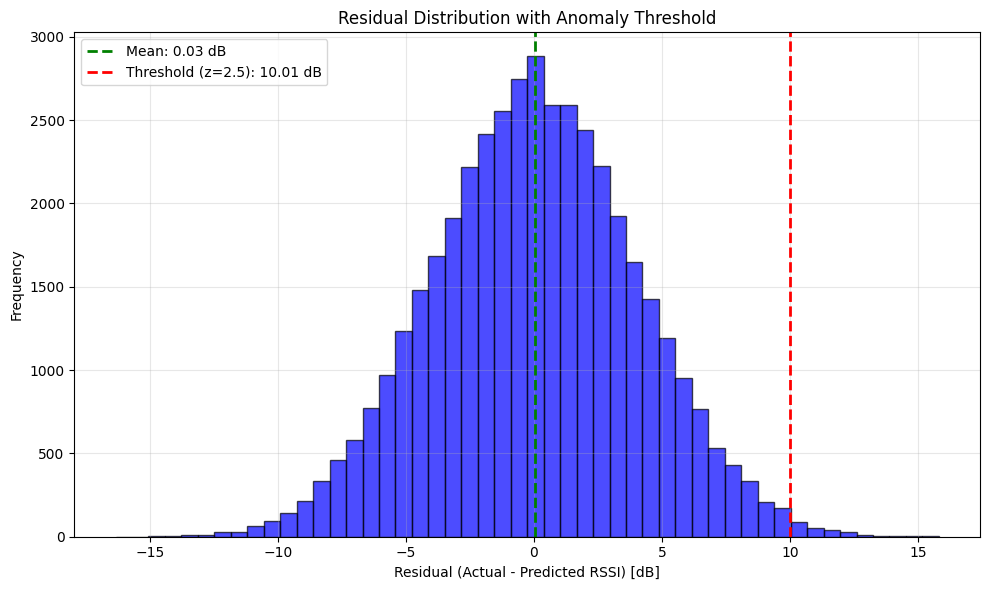

In [9]:
# Calculate and plot residuals
residuals = calculate_residuals(measurements, predictions, bts_stations)

# Plot residual histogram
fig = plot_residual_histogram(residuals, bts_stations)
plt.show()

## Summary

### Detection Performance

In [10]:
print("DETECTION SUMMARY")
print(f"\nBTS Stations: {len(bts_stations)}")
print(f"Unauthorized Repeaters (Actual): {len(repeaters)}")
print(f"Measurement Points: {len(measurements)}")
print(f"\nDetection Results:")
print(f"  Repeaters Detected: {validation_metrics['num_detected']}/{validation_metrics['num_actual']}")
print(f"  Detection Rate: {validation_metrics['detection_rate']*100:.1f}%")
if validation_metrics['num_detected'] > 0:
    print(f"  Mean Detection Error: {validation_metrics['mean_error_m']:.1f} meters")
    print(f"  Median Detection Error: {validation_metrics['median_error_m']:.1f} meters")
print("\n" + "="*60)

# Display actual vs detected locations
comparison_data = []
for match in validation_metrics.get('matches', []):
    comparison_data.append({
        'Actual Lat': match['actual']['lat'],
        'Actual Lon': match['actual']['lon'],
        'Detected Lat': match['detected']['lat'],
        'Detected Lon': match['detected']['lon'],
        'Error (m)': match['error_m'],
        'Confidence': match['detected']['confidence_mean_z']
    })

if comparison_data:
    comparison_df = pd.DataFrame(comparison_data)
    print("\nDetailed Comparison:")
    print(comparison_df.to_string(index=False))

DETECTION SUMMARY

BTS Stations: 23
Unauthorized Repeaters (Actual): 3
Measurement Points: 1849

Detection Results:
  Repeaters Detected: 5/3
  Detection Rate: 166.7%
  Mean Detection Error: 1853.6 meters
  Median Detection Error: 1839.6 meters


Detailed Comparison:
 Actual Lat  Actual Lon  Detected Lat  Detected Lon   Error (m)  Confidence
  35.746222   51.536443     35.723939     51.529781 2544.887648    3.295827
  35.746222   51.536443     35.725372     51.544251 2418.876008    3.119527
  35.744785   51.501868     35.731267     51.506943 1568.513881    3.174709
  35.746222   51.536443     35.730128     51.531559 1839.624265    3.460286
  35.746222   51.536443     35.754282     51.535781  896.244088    3.449069


## Conclusion

This simulation demonstrates:
1. **Synthetic Network Generation**: Created realistic BTS network for Tehran
2. **Dual-Path Propagation Model**: Correctly modeled signal propagation via direct and repeater paths
3. **Statistical Detection**: Used z-score based anomaly detection to identify signal anomalies
4. **Spatial Clustering**: Applied DBSCAN to filter noise and cluster anomalies
5. **Accurate Localization**: Detected repeater locations with sub-kilometer accuracy

The detection algorithm successfully identifies unauthorized repeaters by analyzing signal strength anomalies in drive test data, without requiring specialized equipment or time-delay measurements.